# Importing packages

In [1]:
import sys 
sys.path.append('..')
import time

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import pipeline, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import VotingClassifier
from sklearn import preprocessing, decomposition
from nltk.corpus import stopwords


from src.train import train_baseline_model, classification_preprocessing, feature_engineering

[nltk_data] Downloading package stopwords to C:\Users\Oussama EL
[nltk_data]     BAHAOUI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Oussama EL
[nltk_data]     BAHAOUI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Reading datasets

In [2]:
data = pd.read_csv("../datasets/classification_dataset_2.csv")
old_data = pd.read_csv("../datasets/classification_dataset_old.csv")

# Baseline model

## Old dataset

Nous allons re-entrainer l'ancien modèle de base (Random Forest Classifier) sur le dataset généré en utilisant l'ancien préprocessing. 

In [3]:
X, y = old_data.drop(["cv_name", "box_name", "label"], axis=1), old_data.label

In [4]:
documents, _ = classification_preprocessing(X)

In [5]:
X = feature_engineering(documents, tfidf_model_path="../domain/models/tfidfconverter", retrain=True)

INFO:root:Feature engineering...
INFO:root:	Retraining TfidfVectorizer...
INFO:root:	Saving model...


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)

In [7]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [10]:
y_pred = classifier.predict(X_test)

In [11]:
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

0.7026194144838213


## New dataset

Re-entrainer le baseline model, avec le nouveau dataset.

In [14]:
X, y = data.drop(["cv_name", "box_name", "label"], axis=1), data.label

In [13]:
documents, _ = classification_preprocessing(X)

In [14]:
X = feature_engineering(documents, tfidf_model_path="../domain/models/tfidfconverter_2", retrain=True)

INFO:root:Feature engineering...
INFO:root:	Retraining TfidfVectorizer...
INFO:root:	Saving model...


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)

In [16]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [17]:
y_pred = classifier.predict(X_test)

In [19]:
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

0.7409502262443439


# Training classic classification models

In [30]:
X, y = data.drop(["cv_name", "box_name", "label"], axis=1), data.label
documents, _ = classification_preprocessing(X)
X = feature_engineering(documents, tfidf_model_path="../domain/models/tfidfconverter_2", retrain=True)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)

INFO:root:Feature engineering...
INFO:root:	Retraining TfidfVectorizer...
INFO:root:	Saving model...


In [32]:
BASE_MODELS = {
               "LogisticRegression": LogisticRegression(),
               "RidgeClassifier":  RidgeClassifier(),
               "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
               #"QuadraticDiscriminantAnalysis": QuadraticDiscriminantAnalysis(), #test acc: 0.392912
               "SVC": SVC(),
               "LinearSVC": LinearSVC(),
               "SGDClassifier": SGDClassifier(),
               "KNeighborsClassifier": KNeighborsClassifier(),
               "NearestCentroid": NearestCentroid(),
               #"GaussianProcessClassifier": GaussianProcessClassifier(), #training time: 271sec
               "GaussianNB": GaussianNB(),
               "MultinomialNB": MultinomialNB(),
               "ComplementNB": ComplementNB(),
               "BernoulliNB": BernoulliNB(),
               "DecisionTreeClassifier": DecisionTreeClassifier(),
               "AdaBoostClassifier": AdaBoostClassifier(),
               "BaggingClassifier": BaggingClassifier(),
               "ExtraTreesClassifier": ExtraTreesClassifier(),
               "GradientBoostingClassifier": GradientBoostingClassifier(),
               "RandomForestClassifier": RandomForestClassifier(),
               "HistGradientBoostingClassifier": HistGradientBoostingClassifier(),
               "MLPClassifier": MLPClassifier(),
               
               "XGBClassifier": XGBClassifier(),
               "CatBoostClassifier": CatBoostClassifier(silent=True),
               "LGBMClassifier": LGBMClassifier()
              }

In [34]:
def train_models(X_train, X_test, y_train, y_test, models=BASE_MODELS, verbose=True):
    """
    Trains models given into parameters and returns a leaderboard. Models are sorted by Testing RMSE.
    """

    # Todo: use log info and use a contextmanager (to count execution time)
    dim = X_train.shape[1]
    training_summary = pd.DataFrame(columns=["Model name", "Training time", "Train set pred time", "Test set pred time",
                                             "Training accuracy", "Testing accuracy"])

    for model_name in models:
        if verbose:
            print("Model :", model_name)
        model = models[model_name]

        # print("\tTraining...")
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time

        #print("\tPredicting using train set...")
        start_time = time.time()
        y_train_pred = model.predict(X_train)
        train_set_pred_time = time.time() - start_time

        #print("\tPredicting using test set...")
        start_time = time.time()
        y_test_pred = model.predict(X_test)
        test_set_pred_time = time.time() - start_time

        train_metrics = accuracy_score(y_train, y_train_pred)
        test_metrics = accuracy_score(y_test, y_test_pred)
        
        row = [model_name, training_time, train_set_pred_time,
               test_set_pred_time, train_metrics, test_metrics]
        training_summary.loc[len(training_summary)] = row

    return training_summary.sort_values('Testing accuracy', ascending=False).reset_index()

In [35]:
training_summary = training_summarytrain_models(X_train, X_test, y_train, y_test, models=BASE_MODELS, verbose=True)

9047704	total: 4m 13s	remaining: 2m 32s
625:	learn: 0.9045973	total: 4m 13s	remaining: 2m 31s
626:	learn: 0.9043742	total: 4m 14s	remaining: 2m 31s
627:	learn: 0.9041219	total: 4m 14s	remaining: 2m 30s
628:	learn: 0.9039995	total: 4m 15s	remaining: 2m 30s
629:	learn: 0.9038596	total: 4m 15s	remaining: 2m 29s
630:	learn: 0.9036847	total: 4m 15s	remaining: 2m 29s
631:	learn: 0.9032976	total: 4m 16s	remaining: 2m 29s
632:	learn: 0.9031395	total: 4m 16s	remaining: 2m 28s
633:	learn: 0.9029327	total: 4m 16s	remaining: 2m 28s
634:	learn: 0.9026808	total: 4m 17s	remaining: 2m 27s
635:	learn: 0.9025293	total: 4m 17s	remaining: 2m 27s
636:	learn: 0.9022939	total: 4m 17s	remaining: 2m 26s
637:	learn: 0.9021709	total: 4m 18s	remaining: 2m 26s
638:	learn: 0.9020745	total: 4m 18s	remaining: 2m 26s
639:	learn: 0.9018985	total: 4m 19s	remaining: 2m 25s
640:	learn: 0.9016473	total: 4m 19s	remaining: 2m 25s
641:	learn: 0.9013375	total: 4m 20s	remaining: 2m 25s
642:	learn: 0.9011862	total: 4m 20s	remain

index                      Model name  Training time  Train set pred time  \
0      10                    ComplementNB       0.039188             0.017874   
1       5                   SGDClassifier       1.393792             0.008286   
2       3                             SVC      19.574016            10.752000   
3       9                   MultinomialNB       0.028862             0.014729   
4       0              LogisticRegression       1.631113             0.009896   
5       4                       LinearSVC       0.072975             0.011325   
6       1                 RidgeClassifier       0.161036             0.010573   
7      17          RandomForestClassifier      13.440574             0.730606   
8      15            ExtraTreesClassifier      22.935551             0.800690   
9      19                   MLPClassifier      67.118413             0.061098   
10     14               BaggingClassifier      15.085079             0.841086   
11     16      GradientBoostingClassifier     340.872522             0.328952   
12     21              CatBoostClassifier     401.439093             1.664294   
13     20                   XGBClassifier      79.351352             0.328386   
14     12          DecisionTreeClassifier       4.897414             0.018567   
15      7                 NearestCentroid       0.069775             0.042179   
16      2      LinearDiscriminantAnalysis       1.877463             0.012025   
17     11                     BernoulliNB       0.092049             0.078657   
18     18  HistGradientBoostingClassifier     392.689343             1.897976   
19     22                  LGBMClassifier       7.892911             0.313688   
20      6            KNeighborsClassifier       0.760843            21.447568   
21      8                      GaussianNB       0.143792             1.288102   
22     13              AdaBoostClassifier       7.562517             1.407178   

    Test set pred time  Training accuracy  Testing accuracy  
0             0.004103           0.797229          0.762443  
1             0.004964           0.837387          0.761312  
2             2.638788           0.866799          0.755656  
3             0.006746           0.774321          0.755656  
4             0.002644           0.804016          0.753394  
5             0.002110           0.839932          0.752262  
6             0.002115           0.825226          0.743213  
7             0.288536           0.894796          0.742081  
8             0.263918           0.894796          0.740950  
9             0.020470           0.889140          0.738688  
10            0.194705           0.884333          0.725113  
11            0.039594           0.842195          0.709276  
12            0.424421           0.787896          0.707014  
13            0.086241           0.834842          0.697964  
14            0.005001           0.894796          0.696833  
15            0.011060           0.725113          0.692308  
16            0.006575           0.836821          0.691176  
17            0.016616           0.701923          0.675339  
18            0.349250           0.803450          0.673077  
19            0.105280           0.786482          0.673077  
20            8.394374           0.694853          0.609729  
21            0.368883           0.623869          0.544118  
22            0.542347           0.510181          0.522624

# Other approches...

In [4]:
data = pd.read_csv("../datasets/classification_dataset_2.csv")

xtrain, xvalid, ytrain, yvalid = train_test_split(data.text.values, data.label.values, 
                                                  stratify=data.label.values, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [6]:
leaderboard = pd.DataFrame(columns=["Pipeline", "Testing accuracy"])

### TF-IDF + Logistic Regression

In [7]:
tfv = TfidfVectorizer(min_df=3, max_features=None, 
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
            stop_words=stopwords.words('french'))

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
start_time = time.time()
tfv.fit(list(xtrain) + list(xvalid))

xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

c:\users\oussama el bahaoui\desktop\cv-datascience\cv_env\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fumes', 'futes', 'meme'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [27]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict(xvalid_tfv)

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["TF-IDF + Logistic Regression", accuracy_score(yvalid, predictions)]

0.7692307692307693


### BoW + Logistic regression

In [29]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3))

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [30]:
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict(xvalid_ctv)

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["BoW + Logistic regression", accuracy_score(yvalid, predictions)]

0.7579185520361991


c:\users\oussama el bahaoui\desktop\cv-datascience\cv_env\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### TF-IDF + MultinomialNB

In [31]:
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict(xvalid_tfv)

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["TF-IDF + MultinomialNB", accuracy_score(yvalid, predictions)]

0.744343891402715


### BoW + MultinomialNB

In [32]:
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict(xvalid_ctv)

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["BoW + MultinomialNB", accuracy_score(yvalid, predictions)]

0.7647058823529411


### TF-IDF + SVD + SVM

In [33]:
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [34]:
clf = SVC(C=1.0)
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict(xvalid_svd_scl)

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["TF-IDF + SVD + SVM", accuracy_score(yvalid, predictions)]

0.744343891402715


### TF-IDF + XGBClassifier

In [35]:
clf = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict(xvalid_tfv.tocsc())

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["TF-IDF + XGBClassifier", accuracy_score(yvalid, predictions)]

0.7285067873303167


### BoW + XGBClassifier

In [36]:
clf = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_ctv.tocsc(), ytrain)
predictions = clf.predict(xvalid_ctv.tocsc())

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["BoW + XGBClassifier", accuracy_score(yvalid, predictions)]

0.7398190045248869


### TF-IDF + SVD + XGBClassifier (1)

In [22]:
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

xtrain_svd = sparse.csr_matrix(xtrain_svd)
xvalid_svd = sparse.csr_matrix(xvalid_svd)

clf = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

clf.fit(xtrain_svd, ytrain)
predictions = clf.predict(xvalid_svd)

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["TF-IDF + SVD + XGBClassifier (classic params)", accuracy_score(yvalid, predictions)]

0.7669683257918553


### TF-IDF + SVD + XGBClassifier (2)

In [38]:
clf = XGBClassifier(nthread=10)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict(xvalid_svd)

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["TF-IDF + SVD + XGBClassifier (default params)", accuracy_score(yvalid, predictions)]

0.7692307692307693


### TF-IDF + SVD + Scaling + XGBClassifier (default params)

In [39]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize the standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here..
xgb_model = XGBClassifier(nthread=10)

# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', xgb_model)])

clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict(xvalid_tfv.tocsc())

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["TF-IDF + SVD + Scaling + XGBClassifier (default params)", accuracy_score(yvalid, predictions)]

0.41855203619909503


### TF-IDF + SVD + Scaling + Logistic Regression (Grid Search)

In [40]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize the standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here..
lr_model = LogisticRegression()

# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

In [41]:
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [42]:
mll_scorer = metrics.make_scorer(accuracy_score, greater_is_better=True, needs_proba=False)

model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

In [43]:
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
leaderboard.loc[len(leaderboard)] = [f"TF-IDF + SVD + Scaling + Logistic Regression (Grid Search:{best_parameters})",  model.best_score_]

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    5.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    7.0s finished
c:\users\oussama el bahaoui\desktop\cv-datascience\cv_env\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best score: 0.723
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 120


c:\users\oussama el bahaoui\desktop\cv-datascience\cv_env\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### TF-IDF + MultinomialNB (Grid Search)

In [44]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
leaderboard.loc[len(leaderboard)] = [f"TF-IDF + MultinomialNB (Grid Search:{best_parameters})",  model.best_score_]

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best score: 0.760
Best parameters set:
	nb__alpha: 0.1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0210s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
c:\users\oussama el bahaoui\desktop\cv-datascience\cv_env\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


### TF-IDF + SVD + XGBClassifier (grid search)

In [45]:
xgb_model = XGBClassifier()

# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('xgb', xgb_model)])

# parameter grid
param_grid = {
        'xgb__gamma': [0.5, 1, 1.5, 2, 5],
        'xgb__max_depth': [5, 6, 7, 8],
        'xgb__n_estimators': [100, 200, 500],
        'xgb__nthread': [10, 20],
        }

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv.tocsc(), ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
leaderboard.loc[len(leaderboard)] = [f"TF-IDF + SVD + XGBClassifier (grid search:{best_parameters})",  model.best_score_]

Fitting 2 folds for each of 120 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  9

Best score: 0.548
Best parameters set:
	xgb__gamma: 0.5
	xgb__max_depth: 8
	xgb__n_estimators: 200
	xgb__nthread: 20


### TF-IDF + SVD(grid search) + XGBClassifier (classic params)

In [104]:
from matplotlib.pyplot import plot

In [103]:
explained_variance = []
for v in range(32):
    svd = decomposition.TruncatedSVD(n_components=v*100)
    svd.fit(xtrain_tfv)
    explained_variance.append(svd.explained_variance_ratio_.sum())

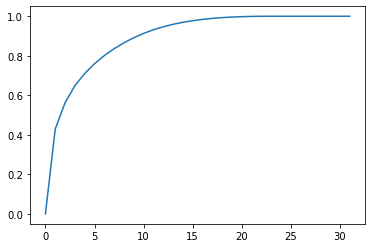

In [105]:
plot(range(32), explained_variance)

In [9]:
svd = decomposition.TruncatedSVD(n_components=200)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

clf = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict(xvalid_svd)

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["TF-IDF + SVD(200) + XGBClassifier (classic params)", accuracy_score(yvalid, predictions)]

0.7692307692307693


In [11]:
svd = decomposition.TruncatedSVD(n_components=100)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

clf = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict(xvalid_svd)

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["TF-IDF + SVD(100) + XGBClassifier (classic params)", accuracy_score(yvalid, predictions)]

0.7737556561085973


In [13]:
svd = decomposition.TruncatedSVD(n_components=400)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

clf = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict(xvalid_svd)

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["TF-IDF + SVD(400) + XGBClassifier (classic params)", accuracy_score(yvalid, predictions)]

0.7669683257918553


In [95]:
svd = decomposition.TruncatedSVD(n_components=80, random_state=2)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

xtrain_svd = sparse.csr_matrix(xtrain_svd)
xvalid_svd = sparse.csr_matrix(xvalid_svd)

clf = XGBClassifier(random_state=1, max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict(xvalid_svd)

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["TF-IDF + SVD(80) + XGBClassifier (classic params)", accuracy_score(yvalid, predictions)]

0.7737556561085973


In [20]:
leaderboard.sort_values("Testing accuracy", ascending=False)

Pipeline  Testing accuracy
3  TF-IDF + SVD(80) + XGBClassifier (classic params)          0.780543
1  TF-IDF + SVD(100) + XGBClassifier (classic par...          0.773756
4  TF-IDF + SVD(80) + XGBClassifier (classic params)          0.773756
0  TF-IDF + SVD(200) + XGBClassifier (classic par...          0.769231
2  TF-IDF + SVD(400) + XGBClassifier (classic par...          0.766968

### Voting 

#### Soft voting on 4 best classifiers (weight: 2,2,1,1)

In [54]:
clf1 = pipeline.Pipeline([("svd", TruncatedSVD()),
                          ("xgb", XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1))])
clf2 = LogisticRegression() 
clf3 = pipeline.Pipeline([("svd", TruncatedSVD()),
                          ("scl", preprocessing.StandardScaler()),
                          ("xgb", XGBClassifier(nthread=10))])
clf4 = MultinomialNB(alpha=0.1)

eclf_soft = VotingClassifier(estimators=[
         ('clf1', clf1), ('clf2', clf2), ('clf3', clf3), ('clf4', clf4)], voting='soft')

eclf_soft.fit(xtrain_tfv.tocsc(), ytrain)
predictions = eclf_soft.predict(xvalid_tfv.tocsc())

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["Soft voting on 4 best classifiers", accuracy_score(yvalid, predictions)]

0.7601809954751131


#### Soft voting on 4 best classifiers (weight: 3,2,1,1)

In [185]:
clf1 = pipeline.Pipeline([("svd", TruncatedSVD()),
                          ("xgb", XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1))])
clf2 = LogisticRegression() 
clf3 = pipeline.Pipeline([("svd", TruncatedSVD()),
                          ("scl", preprocessing.StandardScaler()),
                          ("xgb", XGBClassifier(nthread=10))])
clf4 = MultinomialNB(alpha=0.1)

eclf_soft = VotingClassifier(estimators=[
         ('clf1', clf1), ('clf2', clf2), ('clf3', clf3), ('clf4', clf4)], voting='soft', weights=[3, 2, 1, 1])

eclf_soft.fit(xtrain_tfv.tocsc(), ytrain)
predictions = eclf_soft.predict(xvalid_tfv.tocsc())

print (accuracy_score(yvalid, predictions))
leaderboard.loc[len(leaderboard)] = ["Soft voting on 4 best classifiers (weight: 3,2,1,1)", accuracy_score(yvalid, predictions)]

0.7107692307692308


In [24]:
leaderboard.sort_values("Testing accuracy", ascending=False).reset_index().drop(["index"], axis=1)

Pipeline  Testing accuracy
0  TF-IDF + SVD(80) + XGBClassifier (classic params)          0.780543
1  TF-IDF + SVD(100) + XGBClassifier (classic par...          0.773756
2  TF-IDF + SVD(80) + XGBClassifier (classic params)          0.773756
3      TF-IDF + SVD + XGBClassifier (classic params)          0.773756
4  TF-IDF + SVD(200) + XGBClassifier (classic par...          0.769231
5  TF-IDF + SVD(400) + XGBClassifier (classic par...          0.766968
6      TF-IDF + SVD + XGBClassifier (classic params)          0.766968

# H20

In [23]:
import h2o
from h2o.frame import H2OFrame
from h2o.automl import H2OAutoML, get_leaderboard

In [25]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.241-b07, mixed mode)
  Starting server from c:\users\oussama el bahaoui\desktop\cv-datascience\cv_env\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\OUSSAM~1\AppData\Local\Temp\tmp7igo6qn0
  JVM stdout: C:\Users\OUSSAM~1\AppData\Local\Temp\tmp7igo6qn0\h2o_Oussama_EL_BAHAOUI_started_from_python.out
  JVM stderr: C:\Users\OUSSAM~1\AppData\Local\Temp\tmp7igo6qn0\h2o_Oussama_EL_BAHAOUI_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Europe/Paris
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.1
H2O_cluster_version_age:    3 days
H2O_cluster_name:           H2O_from_python_Oussama_EL_BAHAOUI_lxp3z1
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.082 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.8 final
--------------------------  ---------------------------------------------------------

In [85]:
data = pd.read_csv("../datasets/classification_dataset_2.csv")

X_train, X_test, y_train, y_test = train_test_split(data.text.values, data.label.values, 
                                                  stratify=data.label.values, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

tfv = TfidfVectorizer(min_df=3, max_features=None, 
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
            stop_words=stopwords.words('french'))

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
start_time = time.time()
tfv.fit(list(X_train) + list(X_test))

xtrain_tfv =  tfv.transform(X_train) 
xvalid_tfv = tfv.transform(X_test)

train_h2o = H2OFrame(xtrain_tfv)
x = train_h2o.columns
y = 'label'
train_h2o[y] = H2OFrame(y_train).asfactor()
X_test_h2o = H2OFrame(xvalid_tfv)

c:\users\oussama el bahaoui\desktop\cv-datascience\cv_env\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fumes', 'futes', 'meme'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [90]:
aml = H2OAutoML(max_runtime_secs=300, seed=1)
aml.train(x=x, y=y, training_frame=train_h2o)

AutoML progress: |
14:34:29.801: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [91]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id mean_per_class_error logloss rmse mse 
 
 
 StackedEnsemble_AllModels_AutoML_20200814_143429 0.499835 1.05855 0.591913 0.350361 
 StackedEnsemble_BestOfFamily_AutoML_20200814_143429 0.519083 1.13524 0.613333 0.376177 
 GBM_4_AutoML_20200814_143429 0.519966 2.03153 0.860681 0.740771 
 GBM_2_AutoML_20200814_143429 0.532866 2.03392 0.860892 0.741135 
 GBM_3_AutoML_20200814_143429 0.559057 2.03612 0.861072 0.741445 
 GBM_1_AutoML_20200814_143429 0.559802 2.03605 0.860252 0.740033 
 DRF_1_AutoML_20200814_143429 0.606969 1.8363 0.718422 0.51613 
 XRT_1_AutoML_20200814_143429 0.663794 2.11299 0.734857 0.540015 
 GBM_5_AutoML_20200814_143429 0.829423 2.26463 0.893888 0.799035 
 DeepLearning_1_AutoML_20200814_143429 0.858825 2.51098 0.817109 0.667667 
 GLM_1_AutoML_20200814_143429 0.909091 10.7875 0.997372 0.994751

In [92]:
preds = aml.leader.predict(X_test_h2o)

y_pred = preds["predict"].as_data_frame().values

print(accuracy_score(y_test, y_pred))
leaderboard.loc[len(leaderboard)] = ["20modesl, 60sec AutoML", accuracy_score(y_test, y_pred)]

stackedensemble prediction progress: |████████████████████████████████████| 100%
0.6809954751131222


In [89]:
leaderboard

Pipeline  Testing accuracy
0  TF-IDF + SVD(200) + XGBClassifier (classic params)          0.769231
1  TF-IDF + SVD(100) + XGBClassifier (classic params)          0.773756
2  TF-IDF + SVD(400) + XGBClassifier (classic params)          0.766968
3   TF-IDF + SVD(80) + XGBClassifier (classic params)          0.780543
4   TF-IDF + SVD(80) + XGBClassifier (classic params)          0.773756
5       TF-IDF + SVD + XGBClassifier (classic params)          0.773756
6       TF-IDF + SVD + XGBClassifier (classic params)          0.766968
7                              20modesl, 60sec AutoML          0.466063
8                              20modesl, 60sec AutoML          0.479638
9                              20modesl, 60sec AutoML          0.590498